# Station Outlier filter

This notebook shows the "station outlier filter" to detect... 

The original R code stems from https://github.com/LottedeVos/PWSQC/. 

Publication:
de Vos, L. W., Leijnse, H., Overeem, A., & Uijlenhoet, R. (2019). Quality control for crowdsourced personal weather stations to enable operational rainfall monitoring. _Geophysical Research Letters_, 46(15), 8820-8829.

The idea of the filter is to... 

In [2]:
# Import packages

import warnings

import numpy as np
import xarray as xr
import poligrain as plg
import matplotlib.pyplot as plt
import pandas as pd

import time

In [3]:
#ds_pws = xr.open_dataset('C:/Users/a002461/OPENSENSE/data/OpenSense_PWS_data_FZ_filtered_rainfall.nc')
ds_pws = xr.open_dataset('OpenSense_PWS_example_format_data.nc')

In [4]:
#slice to one month
ds_pws = ds_pws.sel(time = slice('2017-07-01','2017-07-31'))

## Calculate distance matrix

In [5]:
ds_pws.coords["x"], ds_pws.coords["y"] = plg.spatial.project_point_coordinates(
    x=ds_pws.longitude, y=ds_pws.latitude, target_projection="EPSG:25832"
)

In [6]:
distance_matrix = plg.spatial.calc_point_to_point_distances(ds_pws, ds_pws)

## Apply SO filter

In [7]:
# Set parameters
mint = 4032
mrain = 100
mmatch = 200
gamma = 0.15
beta = 0.2
n_stat = 2
max_distance = 10e3 # Boolean 2D data array, defining neihbours within max_distance for all stations
#neighbor_matrix = distance_matrix < max_distance

## Define function for one station

In [ ]:
def flag_station_outlier_for_one_station(da_station, da_neighbors, window_length):
    s_station = da_station.to_series()
    s_neighbors = da_neighbors.to_series()
    
    corr = s_station.rolling(window_length, min_periods=1).corr(s_neighbors)
    n_rainy_timesteps = (s_neighbors > 0).rolling(window_length, min_periods=1).sum()
    #return corr
    
    ds = xr.Dataset.from_dataframe(pd.DataFrame({'corr': corr}))
    ds['n_rainy_timesteps'] = xr.DataArray.from_series(n_rainy_timesteps)
    #ds['id'] = ds.id_neighbor.astype(str)
    return ds

In [5]:
#so_flag = pypwsqc.flagging.so_filter(
#    ds_pws.rainfall,
#    ds_pws.nbrs_not_nan,
#    ds_pws.reference,
#    distance_matrix,
#    mint = 4032,
#    mrain = 100,
#    mmatch = 200,
#    gamma = 0.15,
#   beta = 0.2,
#    n_stat = 5,
#    max_distance = 10e3,
#)

In [8]:
# Default Bias Correction Factor
dbc = 1

In [8]:
# Boolean 2D array (id, time) of true (rain > 0) or false (rain =< 0) for all stations and timesteps
rainy_timesteps = ds_pws.rainfall > 0

In [9]:
# cumulative rainy timesteps per station
cum_rainy_timesteps = rainy_timesteps.cumsum(dim="time")

In [53]:
# initalize SO-flag with empty numpy array
so_flag = np.ones_like(ds_pws.rainfall)
biascorrectiontable = np.ones_like(ds_pws.rainfall)

## Testing faster solution without for-loop over time

### one station only

In [ ]:
# loop through the stations (not time). For each station, slice first the whole data set to you period of interest, 
# then slice that data set to only the current station of interest. 
# This only gives nan in correlation ah well

In [83]:
def flag_station_outlier_for_one_station(da_station, da_neighbors, window_length):
    s_station = da_station.to_series()
    s_neighbors = da_neighbors.to_series()
    
    corr = s_station.rolling(window_length, min_periods=1).corr(s_neighbors)
    n_rainy_timesteps = (s_neighbors > 0).rolling(window_length, min_periods=1).sum()
    #return corr
    
    ds = xr.Dataset.from_dataframe(pd.DataFrame({'corr': corr}))
    ds['n_rainy_timesteps'] = xr.DataArray.from_series(n_rainy_timesteps)
    #ds['id'] = ds.id_neighbor.astype(str)
    return ds

In [37]:
#ds_pws_station: the dataset of the current station in question, in the last mint timesteps
# ds_neighbors.rainfall --> rainfall time series of the nbrs
# window lenght = I GUESS THIS IS MINT???
corr = flag_station_outlier_for_one_station(ds_pws_station, ds_neighbors.rainfall, window_length=4000)

In [51]:
type(corr)

xarray.core.dataset.Dataset

In [ ]:
# ams 35 och ams 6 verkar ha some correlation at least

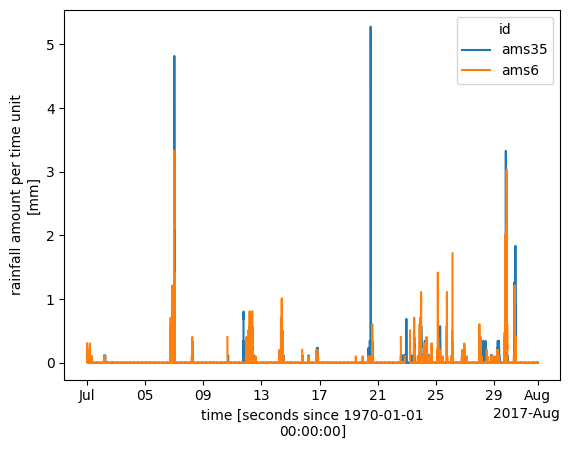

In [50]:
ds_pws.rainfall.sel(id = ["ams35", "ams6"]).plot.line(x="time")

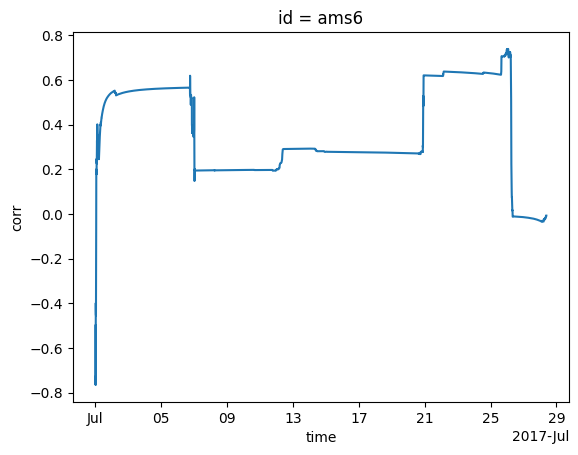

In [44]:
corr.corr[0].plot()

In [27]:
corr.sel(id = 'ams36').corr.data

array([nan, nan, nan, ..., nan, nan, nan])

In [32]:
# loop through the stations (not time). For each station, slice first the whole data set to you period of interest, 
# then slice that data set to only the current station of interest. 

# First attempt with several stations

In [94]:
%%time

max_distance = 10e3

corr_list = []
n_rainy_list = []

for i in range(len(ds_pws.id)):

    # create data set for station i
    ds_station = ds_pws.isel(id=i)
    pws_id = ds_station.id.values

    # one bias correction factor per station, iteratively updated per time step ??
    BCF_prev = dbc

    # picking stations within range, excluding itself
    neighbor_ids = distance_matrix.id.data[(distance_matrix.sel(id=pws_id) < max_distance) & (distance_matrix.sel(id=pws_id) > 0)]
    
    # if there are no observations in the time series, or not enough stations nearby, all timesteps get flagged as -1
    if ds_pws.rainfall.sel(id=pws_id).isnull().all():
        #print(pws_id, " has no data")
        so_flag[i, :] = -1

    elif (len(neighbor_ids) < n_stat):
        #print(pws_id, "has less than", n_stat, "neighbors")
        so_flag[i, :] = -1

    else:
        #print("calculating corr for", pws_id, "with neighbors")
        # ===
        # YOU HAVE TO FIGURE OUT THIS PART

        # filter cannot be applied if less than mmatch overlapping time intvervals
        
        # matches = ds_pws_t_slice.sel(id=neighbor_ids).rainfall.sum().data
        
        # if matches < mmatch:
            #so_flag[i, timestep] = -1
        # ===

        # Correlation
        ds_neighbors = ds_pws.sel(id=neighbor_ids)
        ds_corr = flag_station_outlier_for_one_station(ds_station.rainfall, ds_neighbors.rainfall, window_length=mint)

        # corr['id_neighbor'] = corr.id_neighbor.astype(str)
        corr_list.append(ds_corr.corr.median(dim='id'))
        
ds_pws['median_corr'] = (('id', 'time'), corr_list)
        # Bias

        # Update bias or keep bias 

ValueError: conflicting sizes for dimension 'id': length 110 on 'median_corr' and length 134 on {'time': 'time', 'id': 'id'}

In [70]:
matches = ds_pws_t_slice.sel(id=neighbor_ids).rainfall.sum().data

In [87]:
ds_corr = flag_station_outlier_for_one_station(ds_station.rainfall, ds_neighbors.rainfall, window_length=mint)

In [96]:
np.shape(corr_list)


(110, 8928)

In [92]:
ds_corr

<xarray.Dataset>
Dimensions:            (id: 22, time: 8928)
Coordinates:
  * id                 (id) object 'ams2' 'ams3' 'ams4' ... 'ams24' 'ams26'
  * time               (time) datetime64[ns] 2017-07-01 ... 2017-07-31T23:55:00
Data variables:
    corr               (id, time) float64 nan 1.0 0.5 ... 0.08503 0.0849 0.0849
    n_rainy_timesteps  (id, time) float64 1.0 2.0 3.0 4.0 ... 278.0 279.0 279.0

In [91]:
ds_pws_t_slice.sel(id=neighbor_ids).rainfall

<xarray.DataArray 'rainfall' (id: 22, time: 4032)>
[88704 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 2017-07-01 ... 2017-07-14T23:55:00
  * id         (id) <U6 'ams2' 'ams3' 'ams4' 'ams5' ... 'ams23' 'ams24' 'ams26'
    elevation  (id) <U3 ...
    latitude   (id) float64 52.3 52.31 52.35 52.32 ... 52.26 52.34 52.28 52.28
    longitude  (id) float64 4.675 4.677 4.678 4.679 ... 4.763 4.781 4.783 4.795
    x          (id) float64 2.052e+05 2.054e+05 ... 2.124e+05 2.132e+05
    y          (id) float64 5.803e+06 5.804e+06 5.808e+06 ... 5.8e+06 5.8e+06
Attributes:
    name:                   rainfall
    long_name:              rainfall amount per time unit
    units:                  mm
    coverage_contant_type:  physicalMeasurement

## 25 sept 2024 continue below!

In [ ]:
    # if there are not enough stations nearby, or no observations in the time series, all timesteps get flagged as -1
    if (len(neighbors.id_neighbor) < n_stat) or (
        ds_pws.rainfall.sel(id=pws_id).isnull().all()
    ):
        so_flag[i, :] = -1

    else:
        for j, timestep in enumerate(
            ds_pws.time.isel(time=slice(mint, mint+5)).data, start=mint
        ):
            
            #print(timestep)
            #filter not applied in warmup period
            #if j < mint: ???
                #so_flag[i, j] = -1
                #biascorrectiontable[i,j] = BCF_prev
            #t1 = time.time()
            #if time.time() - tt > 30: # every now and then print some info
                #tt = time.time()
                #print('After 30 sec, station:', i, 'of', len(ds_pws.id), 'timestep:', j, 'of', len(ds_pws.time))
            
            # fixed evaluation period if at least mrain rainy timesteps in the last mint timesteps

            evaluation_period_start = j - mint +1
            evaluation_period_end = j

            # number of rainy timesteps within evaulation period from neighbors
            matches = (
                rainy_timesteps.sel(id=neighbors)
                .isel(time=slice(evaluation_period_start, evaluation_period_end))
                .sum()
                .data
            )

            if matches < mmatch:
            # filter cannot be applied if less than mmatch overlapping time intvervals
                so_flag[i, timestep] = -1

            # THE CODE ABOVE IS NOT THE PROBLEM - FAST COMPUTATION. WORK ON THE CODE BELOW. 

            else:
                # suppress runtime warning
                #print(i, 'filter can be applied')
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=RuntimeWarning)

                    corr_values = np.zeros_like(neighbors, dtype=float)
                    bias_values = np.zeros_like(neighbors, dtype=float)

                    # loop over neighbors
                    for k, neighbor_id in enumerate(neighbors.id_neighbor.data):
                        #print(k)
                        ds_pws_station = ds_pws.rainfall.sel(id=pws_id).isel(
                                time=slice(
                                    evaluation_period_start, evaluation_period_end
                                ))
                        ds_pws_nbr = ds_pws.rainfall.sel(id=neighbor_id).isel(
                                time=slice(
                                    evaluation_period_start, evaluation_period_end
                                )
                            )
                        # pearson correlation with neighboring stations
                        corr = xr.corr(ds_pws_station, ds_pws_nbr)
                        np.corrcoef(ds_pws_station.data, ds_pws_nbr)[0,1]
                        
                        corr_values[k] = corr.data  

                        # rain_pws - rain_reference (can be for example neighboring stations or radar)
                        delta_r = ds_pws_station -ds_pws_nbr 
                        bias = np.nanmean(delta_r) / np.nanmean(ds_pws_nbr)
                     
                        bias_values[k] = bias
                        
                        median_correlation = np.median(corr_values)
                        
                        # if median correlation is above threshold gamma,
                        # calculate new bias correction factor
                        if median_correlation > gamma:
                            #print('correlation is above threshold')
                            bias_values[np.isinf(bias_values)] = np.nan
                            median_bias = np.nanmedian(
                                bias_values
                            )  # median of bias of indivial bias to all neigbors
                            BCF_new = 1 / (1 + median_bias)
                            if np.abs(np.log(BCF_new / BCF_prev)) > np.log(1 + beta):
                                BCF_prev = BCF_new
                                biascorrectiontable[i,j] = BCF_new
                                #print('new BCF')

                        # if the median of the pearson correlation with the neighbors is too low, 
                        # it is a "station outlier"
                        else:
                            so_flag[i, j] = 1
                            biascorrectiontable[i,j] = BCF_prev
                            #print('below threshold, station outlier, previous BCF')
                        t2 = time.time()
            #print('timestep', j, 'took', t2 - t1, 'seconds to run')
    #so_flag.to_pickle('C:/Users/a002461/OPENSENSE/data/'+pws_id+'.pkl')      
    # initialize an empty list, append to the list, convert to xarray

## Only fixed evaluation period

In [36]:
#%load_ext line_profiler

In [29]:
%%time
ds_pws = ds_pws.load()
tt = time.time()

CPU times: total: 0 ns
Wall time: 5.01 ms


In [ ]:
%%time

for i, pws_id in enumerate(ds_pws.id.data):  # enumerate(["ams1", "ams45", "ams17"]):
    #print(pws_id)
    # one bias correction factor per station, iteratively updated per time step
    BCF_prev = dbc
    
    # picking stations within range, excluding itself
    nbrs_within_range = (distance_matrix.sel(id=pws_id) < max_distance) & (
        distance_matrix.sel(id=pws_id) > 0
    )

    # pick neighbors ids, drop all NanNs
    neighbors = (
        distance_matrix.sel(id=pws_id)
        .where(nbrs_within_range, drop=True)
        .id_neighbor
    )
    #print(neighbors.data)

    # if there are not enough stations nearby, or no observations in the time series, all timesteps get flagged as -1
    if (len(neighbors.id_neighbor) < n_stat) or (
        ds_pws.rainfall.sel(id=pws_id).isnull().all()
    ):
        so_flag[i, :] = -1

    else:
        for j, timestep in enumerate(
            ds_pws.time.isel(time=slice(mint, mint+5)).data, start=mint
        ):
            
            #print(timestep)
            #filter not applied in warmup period
            #if j < mint: ???
                #so_flag[i, j] = -1
                #biascorrectiontable[i,j] = BCF_prev
            #t1 = time.time()
            #if time.time() - tt > 30: # every now and then print some info
                #tt = time.time()
                #print('After 30 sec, station:', i, 'of', len(ds_pws.id), 'timestep:', j, 'of', len(ds_pws.time))
            
            # fixed evaluation period if at least mrain rainy timesteps in the last mint timesteps

            evaluation_period_start = j - mint +1
            evaluation_period_end = j

            # number of rainy timesteps within evaulation period from neighbors
            matches = (
                rainy_timesteps.sel(id=neighbors)
                .isel(time=slice(evaluation_period_start, evaluation_period_end))
                .sum()
                .data
            )

            if matches < mmatch:
            # filter cannot be applied if less than mmatch overlapping time intvervals
                so_flag[i, timestep] = -1

            # THE CODE ABOVE IS NOT THE PROBLEM - FAST COMPUTATION. WORK ON THE CODE BELOW. 

            else:
                # suppress runtime warning
                #print(i, 'filter can be applied')
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=RuntimeWarning)

                    corr_values = np.zeros_like(neighbors, dtype=float)
                    bias_values = np.zeros_like(neighbors, dtype=float)

                    # loop over neighbors
                    for k, neighbor_id in enumerate(neighbors.id_neighbor.data):
                        #print(k)
                        ds_pws_station = ds_pws.rainfall.sel(id=pws_id).isel(
                                time=slice(
                                    evaluation_period_start, evaluation_period_end
                                ))
                        ds_pws_nbr = ds_pws.rainfall.sel(id=neighbor_id).isel(
                                time=slice(
                                    evaluation_period_start, evaluation_period_end
                                )
                            )
                        # pearson correlation with neighboring stations
                        corr = xr.corr(ds_pws_station, ds_pws_nbr)
                        np.corrcoef(ds_pws_station.data, ds_pws_nbr)[0,1]
                        
                        corr_values[k] = corr.data  

                        # rain_pws - rain_reference (can be for example neighboring stations or radar)
                        delta_r = ds_pws_station -ds_pws_nbr 
                        bias = np.nanmean(delta_r) / np.nanmean(ds_pws_nbr)
                     
                        bias_values[k] = bias
                        
                        median_correlation = np.median(corr_values)
                        
                        # if median correlation is above threshold gamma,
                        # calculate new bias correction factor
                        if median_correlation > gamma:
                            #print('correlation is above threshold')
                            bias_values[np.isinf(bias_values)] = np.nan
                            median_bias = np.nanmedian(
                                bias_values
                            )  # median of bias of indivial bias to all neigbors
                            BCF_new = 1 / (1 + median_bias)
                            if np.abs(np.log(BCF_new / BCF_prev)) > np.log(1 + beta):
                                BCF_prev = BCF_new
                                biascorrectiontable[i,j] = BCF_new
                                #print('new BCF')

                        # if the median of the pearson correlation with the neighbors is too low, 
                        # it is a "station outlier"
                        else:
                            so_flag[i, j] = 1
                            biascorrectiontable[i,j] = BCF_prev
                            #print('below threshold, station outlier, previous BCF')
                        t2 = time.time()
            #print('timestep', j, 'took', t2 - t1, 'seconds to run')
    #so_flag.to_pickle('C:/Users/a002461/OPENSENSE/data/'+pws_id+'.pkl')      
    # initialize an empty list, append to the list, convert to xarray

## Cell below: variable and fixed evaluation period. I stopped the script after 4 hours, then it was still working on the first station.

In [14]:
%%time

for i, pws_id in enumerate(ds_pws.id.data):  # enumerate(["ams1", "ams45", "ams17"]):
    print(pws_id)
    # one bias correction factor per station, iteratively updated per time step
    BCF_prev = dbc
    
    # picking stations within range, excluding itself
    nbrs_within_range = (distance_matrix.sel(id=pws_id) < max_distance) & (
        distance_matrix.sel(id=pws_id) > 0
    )

    # pick neighbors ids, drop all NanNs
    neighbors = (
        distance_matrix.sel(id=pws_id)
        .where(nbrs_within_range, drop=True)
        .id_neighbor
    )

    # if there are not enough stations nearby, or no observations in the time series, all timesteps get flagged as -1
    if (len(neighbors.id_neighbor) < n_stat) or (
        ds_pws.rainfall.sel(id=pws_id).isnull().all()
    ):
        so_flag[i, :] = -1

    else:
        for j, timestep in enumerate(
            ds_pws.time.isel(time=slice(mint, -1)).data, start=mint
        ):
            #print(timestep)
            #filter not applied in warmup period
            #if j < mint: ???
                #so_flag[i, j] = -1
                #biascorrectiontable[i,j] = BCF_prev

            # fixed evaluation period if at least mrain rainy timesteps in the last mint timesteps
            if (
                cum_rainy_timesteps.sel(id=pws_id, time=timestep)
                - cum_rainy_timesteps.sel(id=pws_id).isel(time=j - mint + 1)
                >= mrain
            ):
                #print('fixed period')
                evaluation_period_start = j - mint +1
                evaluation_period_end = j

            # variable evaluation period if less than mrain rainy timesteps in the last mint timesteps (but before the considered period starts)
            elif (cum_rainy_timesteps.sel(id=pws_id).isel(time=j).data - mrain) > 0:
                start_timestamp = (
                    cum_rainy_timesteps.sel(id=pws_id)
                    .where(
                        cum_rainy_timesteps.sel(id=pws_id).data
                        == (
                            cum_rainy_timesteps.sel(id=pws_id).isel(time=j).data
                            - mrain
                        )
                    )
                    .dropna(dim="time")
                    .time.data
                )
                #print('variable period')
                #print(j)
                start_timestamp = start_timestamp[-1]

                evaluation_period_start = int(
                    ds_pws.number.sel(id=pws_id)
                    .where(
                        ds_pws.number.sel(id=pws_id).time.data == start_timestamp
                    )
                    .dropna(dim="time")
                    .data.item()
                )
                evaluation_period_end = j

            else:  
                # assign -1 to SO filter, we are in the 'warm up period' of the filter
                so_flag[i, j] = -1
                biascorrectiontable[i,j] = BCF_prev
                continue

            # number of rainy timesteps within evaulation period from neighbors
            matches = (
                rainy_timesteps.sel(id=neighbors)
                .isel(time=slice(evaluation_period_start, evaluation_period_end))
                .sum()
                .data
            )

            if matches < mmatch:
            #filter cannot be applied if less than mmatch overlapping time intvervals
                so_flag[i, timestep] = -1

            else:
                # suppress runtime warning
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=RuntimeWarning)

                    corr_values = np.zeros_like(neighbors, dtype=float)
                    bias_values = np.zeros_like(neighbors, dtype=float)

                    # loop over neighbors
                    for k, neighbor_id in enumerate(neighbors.id_neighbor.data):
                        
                        # pearson correlation with neighboring stations
                        corr = xr.corr(
                            ds_pws.rainfall.sel(id=pws_id).isel(
                                time=slice(
                                    evaluation_period_start, evaluation_period_end
                                )
                            ),
                            ds_pws.rainfall.sel(id=neighbor_id).isel(
                                time=slice(
                                    evaluation_period_start, evaluation_period_end
                                )
                            ),
                        )
                        corr_values[k] = corr.data  

                        # rain_pws - rain_reference (can be for example neighboring stations or radar)
                        delta_r = ds_pws.rainfall.sel(id=pws_id).isel(
                            time=slice(evaluation_period_start, evaluation_period_end)
                        ) - ds_pws.rainfall.sel(id=neighbor_id).isel(
                            time=slice(evaluation_period_start, evaluation_period_end)
                        )

                        bias = np.nanmean(delta_r) / np.nanmean(
                            ds_pws.rainfall.sel(id=neighbor_id).isel(
                                time=slice(
                                    evaluation_period_start, evaluation_period_end
                                )
                            )
                        )
                        bias_values[k] = bias
                        
                        median_correlation = np.median(corr_values)
                        
                        # if median correlation is above threshold gamma,
                        # calculate new bias correction factor
                        if median_correlation > gamma:
                            bias_values[np.isinf(bias_values)] = np.nan
                            median_bias = np.nanmedian(
                                bias_values
                            )  # median of bias of indivial bias to all neigbors
                            BCFnew = 1 / (1 + median_bias)
                            if np.abs(np.log(BCFnew / BCF_prev)) > np.log(1 + beta):
                                BCF_prev = BCFnew
                                biascorrectiontable[i,j] = BCF_new

                        # if the median of the pearson correlation with the neighbors is too low, 
                        # it is a "station outlier"
                        else:
                            so_flag[i, j] = 1
                            biascorrectiontable[i,j] = BCF_prev
    so_flag.to_pickle('C:/Users/a002461/OPENSENSE/data/'+pws_id+'.pkl')        


ams1


KeyboardInterrupt: 

In [ ]:
# add flags to dataset
ds_pws["so_flag"] = (("id", "time"), so_flag)
ds_pws["bias"] = (("id", "time"), biascorrectiontable)

In [ ]:
ds_pws.to_netcdf('C:/Users/a002461/OPENSENSE/data/OpenSense_PWS_example_format_data_SO_flags.nc')

## The code block below is not the problem; fast computation

In [35]:
%%time

for i, pws_id in enumerate(["ams1"]):  # enumerate(["ams1", "ams45", "ams17"]): enumerate(ds_pws.id.data): 
    #print(pws_id)
    # one bias correction factor per station, iteratively updated per time step
    BCF_prev = dbc
    
    # picking stations within range, excluding itself
    nbrs_within_range = (distance_matrix.sel(id=pws_id) < max_distance) & (
        distance_matrix.sel(id=pws_id) > 0
    )

    # pick neighbors ids, drop all NanNs
    neighbors = (
        distance_matrix.sel(id=pws_id)
        .where(nbrs_within_range, drop=True)
        .id_neighbor
    )
    #print(neighbors.data)

    # if there are not enough stations nearby, or no observations in the time series, all timesteps get flagged as -1
    if (len(neighbors.id_neighbor) < n_stat) or (
        ds_pws.rainfall.sel(id=pws_id).isnull().all()
    ):
        so_flag[i, :] = -1

    else:
        for j, timestep in enumerate(
            ds_pws.time.isel(time=slice(mint, mint+5)).data, start=mint
        ):
            
            #print(timestep)
            #filter not applied in warmup period
            #if j < mint: ???
                #so_flag[i, j] = -1
                #biascorrectiontable[i,j] = BCF_prev
            #t1 = time.time()
            #if time.time() - tt > 30: # every now and then print some info
                #tt = time.time()
                #print('After 30 sec, station:', i, 'of', len(ds_pws.id), 'timestep:', j, 'of', len(ds_pws.time))
            
            # fixed evaluation period if at least mrain rainy timesteps in the last mint timesteps

            evaluation_period_start = j - mint +1
            evaluation_period_end = j

            # number of rainy timesteps within evaulation period from neighbors
            matches = (
                rainy_timesteps.sel(id=neighbors)
                .isel(time=slice(evaluation_period_start, evaluation_period_end))
                .sum()
                .data
            )
            print(matches)

            if matches < mmatch:
            # filter cannot be applied if less than mmatch overlapping time intvervals
                so_flag[i, timestep] = -1

3677
3662
3646
3629
3612
CPU times: total: 15.6 ms
Wall time: 23.2 ms
